This is a Google Colab notbook, if you wish to run this on local machine you need to download the data from the following link and import them.

positive: https://drive.google.com/file/d/1WXfgRpiHuy-fBjsqZFUw7GoEvoPByd33/view?usp=share_link

negative: https://drive.google.com/file/d/1tHR-qlaVVd54bDxWIEM1b33D2uK4-eVe/view?usp=share_link

In [1]:
!gdown 1WXfgRpiHuy-fBjsqZFUw7GoEvoPByd33
!gdown 1tHR-qlaVVd54bDxWIEM1b33D2uK4-eVe

Downloading...
From: https://drive.google.com/uc?id=1WXfgRpiHuy-fBjsqZFUw7GoEvoPByd33
To: /content/df_positive.csv
100% 1.78G/1.78G [00:06<00:00, 270MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tHR-qlaVVd54bDxWIEM1b33D2uK4-eVe
To: /content/df_negative.csv
100% 1.76G/1.76G [00:05<00:00, 295MB/s]


In [2]:
!ls

df_negative.csv  df_positive.csv  sample_data


In [3]:
import pandas as pd

df_positives = pd.read_csv('/content/df_positive.csv')
df_negatives = pd.read_csv('/content/df_negative.csv')

print(df_positives.shape)
print(df_negatives.shape)

(11217656, 45)
(11217656, 45)


In [4]:
# select 50% of the positive samples to X_train_positive
X_train_positive = df_positives.sample(frac=0.5, random_state=0)

# in the rest 50% of the positive samples, select 20% to X_test_positive
X_test_positive = df_positives.drop(X_train_positive.index)

# drop 50% in X_test_positive
X_test_positive = X_test_positive.sample(frac=0.5, random_state=0)

# get the number of samples in X_test_positive and X_train_positive
n_X_test_positive = X_test_positive.shape[0]
n_X_train_positive = X_train_positive.shape[0]

In [5]:
# select n_X_train_positive/10 samples from the negative samples 10 times and add them to a list
X_train_negative = []
for i in range(5):
    X_train_negative.append(df_negatives.sample(n=n_X_train_positive//10, random_state=i))

# concatenate X_train_positive to each of the samples in X_train_negative list and get 10 X_train datasets
X_train = []
for i in range(5):
    X_train.append(pd.concat([X_train_positive, X_train_negative[i]]))

# select n_X_test_positive/10 samples from the negative samples 10 times and add them to a list
X_test_negative = []
for i in range(5):
    X_test_negative.append(df_negatives.drop(X_train_negative[i].index).sample(n=n_X_test_positive//10, random_state=i))

# concatenate X_test_positive to each of the samples in X_test_negative list and get 10 X_test datasets
X_test = []
for i in range(5):
    X_test.append(pd.concat([X_test_positive, X_test_negative[i]]))

In [6]:
# in X_train and X_test, select the 'target' as y_train and y_test
y_train = []
y_test = []
for i in range(5):
    y_train.append(X_train[i]['target'])
    y_test.append(X_test[i]['target'])

# in X_train and X_test, drop the 'target' column
for i in range(5):
    X_train[i] = X_train[i].drop(['target'], axis=1)
    X_test[i] = X_test[i].drop(['target'], axis=1)

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[0])
X_test_scaled = scaler.transform(X_test[0])

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create the autoencoder model
autoencoder = Sequential([
    Dense(32, activation='relu', input_shape=(44,)),
    Dense(10, activation='relu'),
    Dense(32, activation='relu'),
    Dense(44, activation='sigmoid')  # Use sigmoid because our data is normalized between 0 and 1
])

autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
history = autoencoder.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=10,
    batch_size=256,
    validation_data=(X_test_scaled, X_test_scaled)
)

Epoch 1/10
24101/24101 [==============================] - 86s 3ms/step - loss: 0.9551 - val_loss: 1436.6139
Epoch 2/10
24101/24101 [==============================] - 76s 3ms/step - loss: 0.9541 - val_loss: 1436.6139
Epoch 3/10
24101/24101 [==============================] - 76s 3ms/step - loss: 0.9540 - val_loss: 1436.6139
Epoch 4/10
21031/24101 [=========================>....] - ETA: 7s - loss: 0.9722

KeyboardInterrupt: ignored

In [10]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

# Compute reconstruction errors
reconstructed = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructed, 2), axis=1)

# Set a threshold (for example, based on the 99th percentile of benign samples' reconstruction errors)
threshold = np.quantile(mse, 0.90)

# Classify samples
predictions = (mse < threshold).astype(int)  # This will give 1 for anomalies and 0 for normal samples


96402/96402 [==============================] - 119s 1ms/step


In [11]:
y_pred = pd.DataFrame(predictions)

print(y_pred.value_counts())
print(y_test[0].value_counts())

1    2776369
0     308486
dtype: int64
1    2804414
0     280441
Name: target, dtype: int64


In [12]:
# change all 0 to 1, and 1 to 0 in y_test[0]
y_test_1 = y_test[0].replace(1, -1)
y_test_1 = y_test_1.replace(0, 1)
y_test_1 = y_test_1.replace(-1, 0)

print(y_pred.value_counts())
print(y_test[0].value_counts())

1    2776369
0     308486
dtype: int64
1    2804414
0     280441
Name: target, dtype: int64


In [13]:
# import classification report
from sklearn.metrics import classification_report

# print classification report
print(classification_report(y_test[0], y_pred))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57    280441
           1       0.96      0.95      0.95   2804414

    accuracy                           0.92   3084855
   macro avg       0.75      0.77      0.76   3084855
weighted avg       0.92      0.92      0.92   3084855



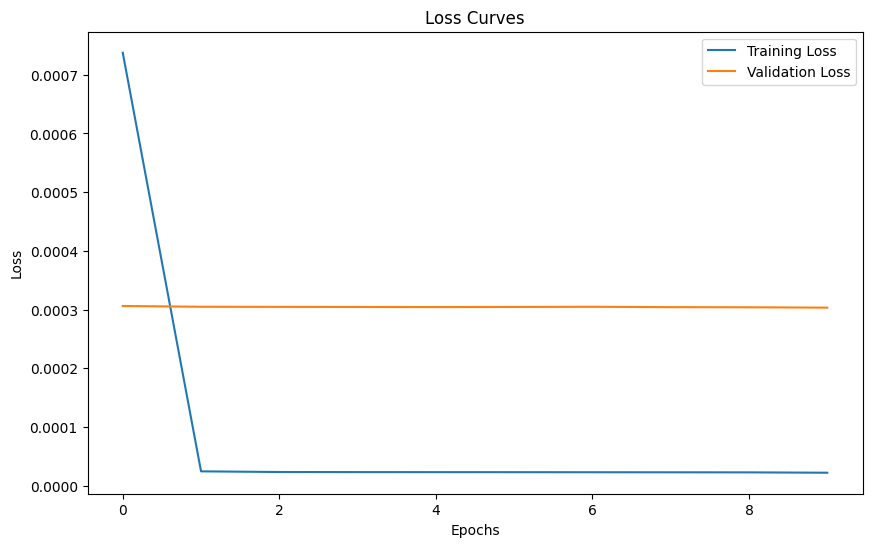

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
